In [98]:
using GLM
using StatsBase
using DataFrames
using Dagitty
using Turing
using StatsPlots
using StatisticalRethinking
using Logging

default(labels=false)
Logging.disable_logging(Logging.Warn);

Code 6.1

In [13]:
Random.seed!(1917)
N = 200   # grant proposals
p = 0.1   # proportion to select

# uncorrelated newsworthiness and trustworthiness
nw = rand(Normal(), N)
tw = rand(Normal(), N)

# select top 10% of combined score
s = nw .+ tw
q = quantile(s, 1-p)
selected = s .>= q
cor(tw[selected], nw[selected])

-0.785212889969301

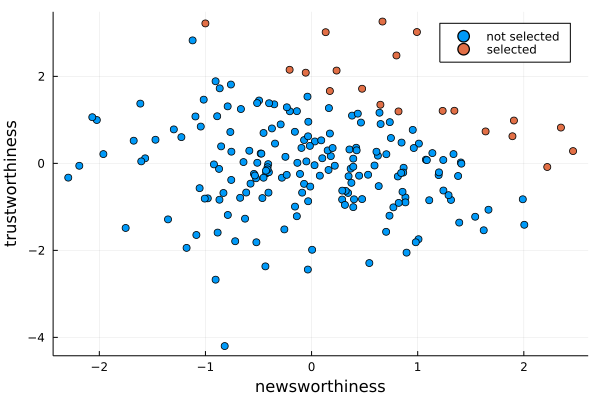

In [24]:
scatter(nw[.!selected], tw[.!selected]; xlab="newsworthiness", ylab="trustworthiness", label="not selected")
scatter!(nw[selected], tw[selected]; label="selected")

# 6.1 Multicollinearity

Code 6.2

In [28]:
Random.seed!(100)
N = 100
height = rand(Normal(10, 2), N)
leg_prop = rand(Uniform(0.4, 0.5), N)
leg_left = leg_prop .* height .+ rand(Normal(0, 0.02), N)
leg_right = leg_prop .* height .+ rand(Normal(0, 0.02), N)
d = DataFrame(:height => height, :leg_left => leg_left, :leg_right => leg_right);

Code 6.3

In [30]:
@model function model_m6_1(leg_left, leg_right, height)
    a ~ Normal(10, 100)
    bl ~ Normal(2, 10)
    br ~ Normal(2, 10)
    μ = @. a + bl * leg_left + br * leg_right
    σ ~ Exponential(1)
    height ~ MvNormal(μ, σ)
end

m6_1 = sample(model_m6_1(d.leg_left, d.leg_right, d.height), NUTS(), 1000)
m6_1_df = DataFrame(m6_1)
precis(m6_1_df)

┌───────┬────────────────────────────────────────────────────────┐
│ param │   mean     std     5.5%     50%   94.5%      histogram │
├───────┼────────────────────────────────────────────────────────┤
│     a │ 0.6338  0.3296    0.091  0.6329  1.1752   ▁▁▁▃▅██▆▃▂▁▁ │
│    bl │ 1.7655    1.96  -1.4323  1.8123  4.8364  ▁▁▂▂▅▇██▅▄▂▁▁ │
│    br │ 0.3122  1.9688   -2.772  0.2748  3.4925  ▁▁▂▄▅██▇▅▃▂▁▁ │
│     σ │ 0.6126  0.0449   0.5446  0.6099  0.6885         ▂▇█▃▁▁ │
└───────┴────────────────────────────────────────────────────────┘


Code 6.4

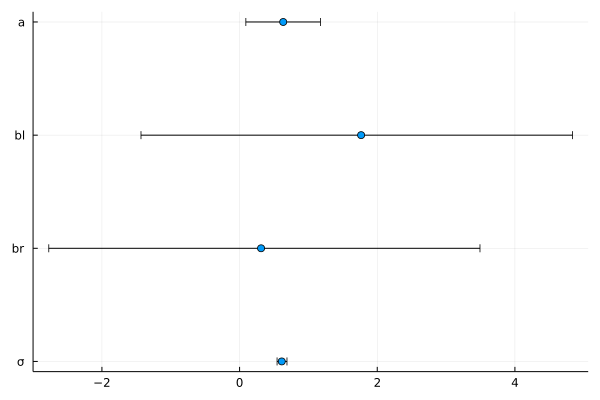

In [31]:
coeftab_plot(m6_1_df)

Code 6.5

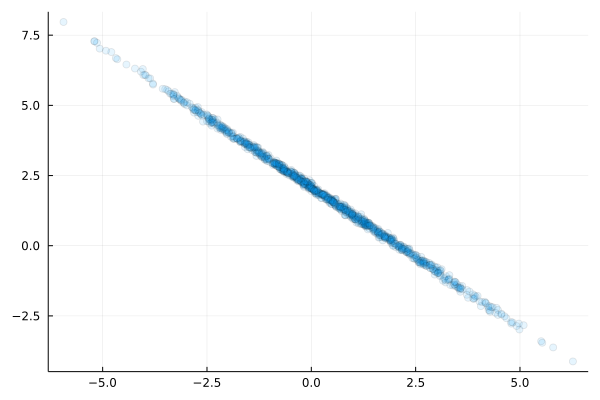

In [33]:
scatter(m6_1_df.br, m6_1_df.bl; alpha=0.1)

Code 6.6

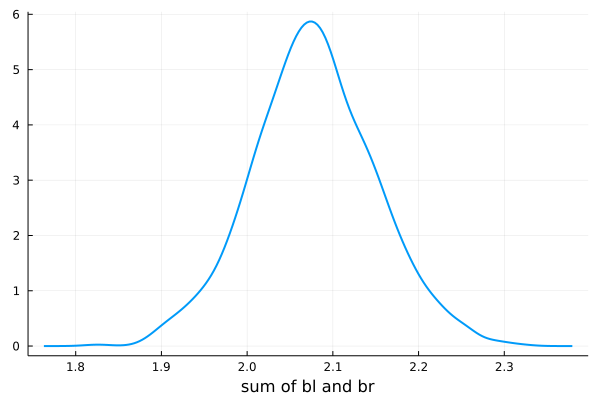

In [36]:
@df m6_1_df density(:br + :bl; lw=2, xlab="sum of bl and br")

Code 6.7

In [37]:
@model function model_m6_2(leg_left, height)
    a ~ Normal(10, 100)
    bl ~ Normal(2, 10)
    μ = @. a + bl * leg_left
    σ ~ Exponential(1)
    height ~ MvNormal(μ, σ)
end

m6_2 = sample(model_m6_2(d.leg_left, d.height), NUTS(), 1000)
m6_2_df = DataFrame(m6_2)
precis(m6_2_df)

┌───────┬────────────────────────────────────────────────────────┐
│ param │   mean     std    5.5%     50%   94.5%       histogram │
├───────┼────────────────────────────────────────────────────────┤
│     a │ 0.6728   0.327  0.1407  0.6611  1.1928    ▁▁▁▂▅▇█▇▄▂▁▁ │
│    bl │ 2.0684  0.0712   1.956  2.0689  2.1783      ▁▁▂▄▇█▆▃▁▁ │
│     σ │ 0.6063  0.0414  0.5434  0.6051  0.6753  ▁▁▂▄▇██▆▄▃▂▁▁▁ │
└───────┴────────────────────────────────────────────────────────┘


In [43]:
std(m6_1_df.bl), std(m6_1_df.br), std(m6_1_df.bl + m6_1_df.br)

(1.9600064957206784, 1.9687730215545687, 0.07174624055531233)

Code 6.8

In [48]:
d = DataFrame(CSV.File("data/milk.csv",  missingstring="NA"))

# get rid of dots in column names
rename!(n -> replace(n, "." => "_"), d)

d[!,:K] = standardize(ZScoreTransform, d.kcal_per_g)
d[!,:F] = standardize(ZScoreTransform, d.perc_fat)
d[!,:L] = standardize(ZScoreTransform, d.perc_lactose);

Code 6.9

In [54]:
@model function model_m6_3(F, K)
    a ~ Normal(0, 0.2)
    bF ~ Normal(0, 0.5)
    μ = @. a + F * bF
    σ ~ Exponential(1)
    K ~ MvNormal(μ, σ)
end

m6_3 = sample(model_m6_3(d.F, d.K), NUTS(), 1000)
m6_3_df = DataFrame(m6_3)

@model function model_m6_4(L, K)
    a ~ Normal(0, 0.2)
    bL ~ Normal(0, 0.5)
    μ = @. a + L * bL
    σ ~ Exponential(1)
    K ~ MvNormal(μ, σ)
end

m6_4 = sample(model_m6_4(d.L, d.K), NUTS(), 1000)
m6_4_df = DataFrame(m6_4)

precis(m6_3_df)
precis(m6_4_df)

┌───────┬────────────────────────────────────────────────────────┐
│ param │   mean     std     5.5%     50%   94.5%      histogram │
├───────┼────────────────────────────────────────────────────────┤
│     a │ 0.0013  0.0831  -0.1318  0.0003   0.132  ▁▁▁▃▆██▆▃▁▁▁▁ │
│    bF │ 0.8563  0.0894   0.7118   0.855  0.9943   ▁▁▁▃▅██▆▄▂▁▁ │
│     σ │  0.489   0.071   0.3891  0.4797  0.6192     ▁▂▆█▅▃▂▁▁▁ │
└───────┴────────────────────────────────────────────────────────┘
┌───────┬──────────────────────────────────────────────────────────┐
│ param │    mean     std     5.5%      50%    94.5%     histogram │
├───────┼──────────────────────────────────────────────────────────┤
│     a │ -0.0002   0.071  -0.1134   0.0006   0.1059    ▁▁▂▆██▆▂▁▁ │
│    bL │ -0.8988  0.0773  -1.0212  -0.9003  -0.7748  ▁▁▁▃▅██▆▃▁▁▁ │
│     σ │  0.4148  0.0584   0.3328   0.4044   0.5184     ▁▃██▄▂▁▁▁ │
└───────┴──────────────────────────────────────────────────────────┘


Code 6.10

In [57]:
@model function model_m6_5(F, L, K)
    a ~ Normal(0, 0.2)
    bF ~ Normal(0, 0.5)
    bL ~ Normal(0, 0.5)
    μ = @. a + F * bF + L * bL
    σ ~ Exponential(1)
    K ~ MvNormal(μ, σ)
end

m6_5 = sample(model_m6_5(d.F, d.L, d.K), NUTS(), 1000)
m6_5_df = DataFrame(m6_5)
precis(m6_5_df)

┌───────┬────────────────────────────────────────────────────────────┐
│ param │    mean     std     5.5%      50%    94.5%       histogram │
├───────┼────────────────────────────────────────────────────────────┤
│     a │  0.0029   0.072  -0.1121    0.002   0.1179    ▁▁▁▂▅██▅▃▁▁▁ │
│    bF │  0.2561  0.1977  -0.0701   0.2607   0.5503   ▁▁▂▃▄▇██▆▃▁▁▁ │
│    bL │ -0.6599  0.2013  -0.9894  -0.6576  -0.3377  ▁▁▁▂▄▄▇██▄▃▂▁▁ │
│     σ │  0.4132  0.0562   0.3335    0.406   0.5094       ▁▃██▄▂▁▁▁ │
└───────┴────────────────────────────────────────────────────────────┘


Code 6.11

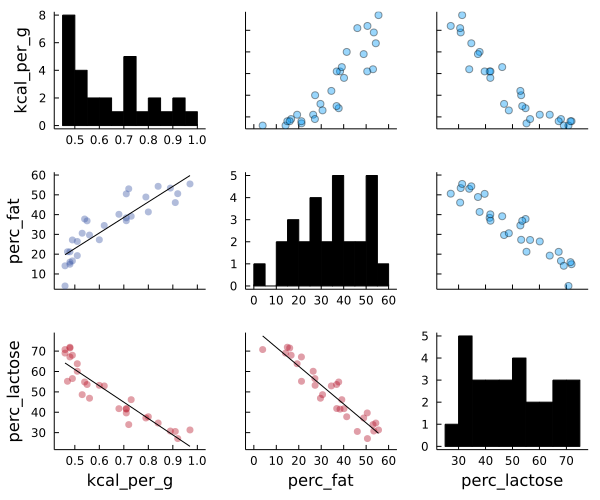

In [91]:
@df d corrplot([:kcal_per_g :perc_fat :perc_lactose]; seriestype=:scatter, bins=10, grid=false)

Code 6.12

In [93]:
r_seq = range(0, 0.99; step=0.01)

0.0:0.01:0.99

In [94]:
var(d.perc_fat)

204.10895344827577

In [101]:
r = 0.8
x = [rand(Normal(r * perc_fat, sqrt(1-r^2)*var(d.perc_fat))) for perc_fat in d.perc_fat];

In [102]:
lm(x .+ d.perc_fat, d.kcal_per_g)

LoadError: MethodError: no method matching fit(::Type{LinearModel}, ::Vector{Float64}, ::Vector{Float64}, ::Nothing)
[0mClosest candidates are:
[0m  fit([91m::StatisticalModel[39m, ::Any...) at /Users/maxim.lapan/.julia/packages/StatsBase/IiL4F/src/statmodels.jl:178
[0m  fit(::Type{T}, [91m::FormulaTerm[39m, ::Any, ::Any...; contrasts, kwargs...) where T<:RegressionModel at /Users/maxim.lapan/.julia/packages/StatsModels/j0Cya/src/statsmodel.jl:78
[0m  fit(::Type{T}, [91m::FormulaTerm[39m, ::Any, ::Any...; contrasts, kwargs...) where T<:StatisticalModel at /Users/maxim.lapan/.julia/packages/StatsModels/j0Cya/src/statsmodel.jl:78
[0m  ...

In [100]:
methods(lm)

# 2 methods for generic function "lm":
[1] lm(X, y) in GLM at /Users/maxim.lapan/.julia/packages/GLM/5CcRd/src/lm.jl:179
[2] lm(X, y, allowrankdeficient_dep::Union{Nothing, Bool}; kwargs...) in GLM at /Users/maxim.lapan/.julia/packages/GLM/5CcRd/src/lm.jl:179